In [1]:
import os
import requests
from pprint import pprint
import pandas as pd
import json
import sys
import seaborn as sns
import matplotlib.pyplot as plt

# Fill in your credentials
subscription_key = ""
endpoint = ""

"""
Credit: Andy Wang, Gaurav Shah, Rafael Ostrea
Microsoft x PiE Datathon
"""

"""
The code in this section isn't required, unless you want to hide your subscription credentials from the public.
Look into python-dotenv for more information.
authenticate_client() uses the Text Analytics SDK to create a client

# from dotenv import load_dotenv
# load_dotenv()
# subscription_key = os.getenv('SUBSCRIPTION_KEY')
# endpoint = os.getenv('ENDPOINT')

# def authenticate_client():
#     ta_credential = AzureKeyCredential(subscription_key)
#     text_analytics_client = TextAnalyticsClient(
#             endpoint= endpoint, credential=ta_credential)
#     return text_analytics_client
"""

def sentiment_analysis_example(documents):
    sentiment_url = endpoint + "/text/analytics/v3.0/sentiment"
    headers = {"Ocp-Apim-Subscription-Key": subscription_key}
    response = requests.post(sentiment_url, headers=headers, json=documents)
    sentiments = response.json()

    return sentiments


def extract_key_phrases(documents):
    keyphrase_url = endpoint + "/text/analytics/v3.0/keyphrases"
    headers = {"Ocp-Apim-Subscription-Key": subscription_key}
    response = requests.post(keyphrase_url, headers=headers, json=documents)
    key_phrases = response.json()

    return key_phrases


def identify_entities(documents):
    entities_url = endpoint + "/text/analytics/v3.0/entities/recognition/general"
    headers = {"Ocp-Apim-Subscription-Key": subscription_key}
    response = requests.post(entities_url, headers=headers, json=documents)
    entities = response.json()
    pprint(entities)


def convert_text_to_JSON(data):
    """
    Convert text data to the format required by the
    Text Analytics API. Example format included below in the main function.
    """
    data.insert(2, "language", "en", True)
    data = data.rename(columns={"SupportTicketID": "id", "language": "language", "Text": "text"})
    data = pd.DataFrame(data, columns=['id','language','text'])
    data.applymap(str)
    return data


def parse_output(output_JSON):
    """
    Convert the response body from the API request to
    select the values you want.
    """
    pass

"""
Given list of sentiment JSON data in CHUNKS, checks the proportion of items with given SENTIMENT
in list. Each item will fall under SENTIMENT if the sentiment score is greater than or
equal to the THRESHOLD value, default of which is 0.5. Returns the sentiment and the percentage
in a string format for print statements.
"""
def sentiment_proportion(chunks, sentiment, threshold = 0.5):
    numTotal = 0
    numS = 0
    for chunk in chunks:
        for item in chunk["documents"]:
            check = item['confidenceScores'][sentiment]
            if check >= threshold:
                numS += 1
            numTotal += 1
    return sentiment+" percentage: "+"{0:.2f}%".format(numS/numTotal * 100)


"""
Input df, chunk_size
Will return list CHUNKS which contains sentiment analysis of blocks of 10 rows of DF at a time.
"""
def split_dataframe(df, chunk_size = 10):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        ten = df[i*chunk_size:(i+1)*chunk_size]
        dict = ten.to_dict('records')
        format = {"documents":dict}
        sentiment = sentiment_analysis_example(format)
        chunks.append(sentiment)
    return chunks

"""
Given list of sentiment JSON data in CHUNKS, checks the proportion of items with given SENTIMENT
in list. Each item will fall under SENTIMENT if the sentiment score is greater than or
equal to the THRESHOLD value, default of which is 0.5. Returns the sentiment and the percentage
as a float value.
"""
def sentiment_proportion_num(chunks, sentiment, threshold = 0.5):
    numTotal = 0
    numS = 0
    for chunk in chunks:
        for item in chunk["documents"]:
            check = item['confidenceScores'][sentiment]
            if check >= threshold:
                numS += 1
            numTotal += 1
    return numS/numTotal * 100


"""
Input df, chunk_size
Will return list CHUNKS which contains keyword analysis of blocks of 10 rows of DF at a time.
"""
def split_keyword(df, chunk_size = 10):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        ten = df[i*chunk_size:(i+1)*chunk_size]
        dict = ten.to_dict('records')
        format = {"documents":dict}
        keywords = extract_key_phrases(format)
        chunks.append(keywords)
    return chunks

In [2]:
documents = {"documents": [
        {"id": "1", "language": "en",
            "text": "I do not like this hammer made by Black & Decker. It does not work correctly. I want to request a return."},
        {"id": "2", "language": "es",
            "text": "I've been trying to talk to someone about my sink problem. It won't hold all of my fish."}
    ]}


#suppresses chained assignment warning as we are not editing the original table
pd.options.mode.chained_assignment = None

#extracting from csv file
prod_data = pd.read_csv("support_ticket_data.csv", encoding='Windows-1252')

#Returns data as pandas data frame
df = pd.DataFrame(prod_data, columns= ['SupportTicketID', 'Text', 'Theme'])



#categories
df['Theme'] = pd.Categorical(df['Theme'], categories=['design','features','price','reliability','security','services','speed','support', 'other'],ordered=True)
design = df[df['Theme'] == "design"]
features = df[df['Theme'] == "features"]
price = df[df['Theme'] == "price"]
reliability = df[df['Theme'] == "reliability"]
security = df[df['Theme'] == "security"]
services = df[df['Theme'] == "services"]
speed = df[df['Theme'] == "speed"]
support = df[df['Theme'] == "support"]
other = df[df['Theme'] == "other"]

categories = [design, features, price, reliability, security, services, speed, support, other]
dicts = {}
numResponses = {}

#Converts each subtable into the JSON format for sentiment analysis
for i in categories:
    theme = i.iloc[0]['Theme']
    numResponses[theme] = len(i)
    dicts[theme] = convert_text_to_JSON(i)

In [ ]:
print("Which category do you want to analyze?")
print("Categories: design, features, price")
print("reliability, security, services")
print("speed, support, other")
print()
category = str(input())
while True:
    if category in dicts:
        val = dicts[category]
        chunks = split_dataframe(val, 10)
        print()
        print("Number of Responses: " + str(numResponses[category]))
        print(sentiment_proportion(chunks, 'positive', 0.51))
        print(sentiment_proportion(chunks, 'neutral', 0.51))
        print(sentiment_proportion(chunks,'negative',0.51))
        print()
        print("Do you want to do another analysis? If so, enter yes. If not, enter any other string.")
        response = str(input())
        if response == "yes":
            print()
            print("Which category do you want to analyze?")
            print("Categories: design, features, price")
            print("reliability, security, services")
            print("speed, support, other")
            print()
            category = str(input())
            continue
        break    
    else:
        print()
        print("That is not a valid category. Please input a valid category.")
        print("Categories: design, features, price")
        print("reliability, security, services")
        print("speed, support, other")
        print()
        category = str(input())

Which category do you want to analyze?
Categories: design, features, price
reliability, security, services
speed, support, other

design

Number of Responses: 18
positive percentage: 16.67%
neutral percentage: 16.67%
negative percentage: 66.67%

Do you want to do another analysis? If so, enter yes. If not, enter any other string.
yes

Which category do you want to analyze?
Categories: design, features, price
reliability, security, services
speed, support, other

features

Number of Responses: 49
positive percentage: 14.29%
neutral percentage: 42.86%
negative percentage: 38.78%

Do you want to do another analysis? If so, enter yes. If not, enter any other string.


In [4]:
categories = dicts.keys()
negProp = []
posProp = []
neuProp = []
for x in categories:
    y = dicts[x]
    chunks = split_dataframe(y, 10)
    neg = sentiment_proportion_num(chunks, 'negative', 0.51)
    pos = sentiment_proportion_num(chunks, 'positive', 0.51)
    neu = sentiment_proportion_num(chunks, 'neutral', 0.51)
    
    
    print("\n{} Positive Sentiment: {:0.2f}%".format(x.capitalize(), pos))
    print("{} Neutral Sentiment: {:0.2f}%".format(x.capitalize(), neu))
    print("{} Negative Sentiment: {:0.2f}%".format(x.capitalize(), neg))

    negProp.append(neg)
    posProp.append(pos)
    neuProp.append(neu)


Design Positive Sentiment: 16.67%
Design Neutral Sentiment: 16.67%
Design Negative Sentiment: 66.67%

Features Positive Sentiment: 14.29%
Features Neutral Sentiment: 42.86%
Features Negative Sentiment: 38.78%

Price Positive Sentiment: 11.86%
Price Neutral Sentiment: 37.29%
Price Negative Sentiment: 49.15%

Reliability Positive Sentiment: 16.13%
Reliability Neutral Sentiment: 22.58%
Reliability Negative Sentiment: 58.06%

Security Positive Sentiment: 3.85%
Security Neutral Sentiment: 53.85%
Security Negative Sentiment: 38.46%

Services Positive Sentiment: 5.88%
Services Neutral Sentiment: 44.12%
Services Negative Sentiment: 50.00%

Speed Positive Sentiment: 12.99%
Speed Neutral Sentiment: 45.45%
Speed Negative Sentiment: 37.66%

Support Positive Sentiment: 14.29%
Support Neutral Sentiment: 52.38%
Support Negative Sentiment: 28.57%

Other Positive Sentiment: 30.77%
Other Neutral Sentiment: 15.38%
Other Negative Sentiment: 53.85%


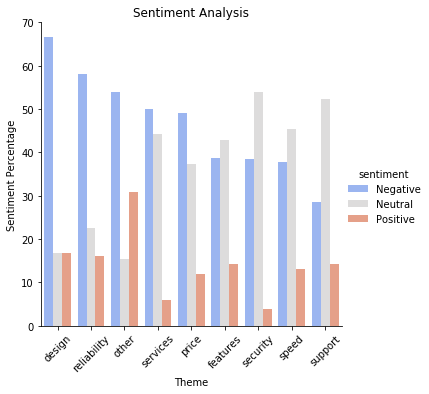

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt



df = pd.DataFrame({ 'Negative': negProp, 'Neutral': neuProp,'Positive': posProp,}, index=categories)
df = df.sort_values(by='Negative', ascending=False)
df.reset_index(level=0, inplace=True)
df = pd.melt(df, id_vars="index", var_name="sentiment", value_name="percentage")


sns.catplot(x='index', y='percentage', hue='sentiment', data=df, kind='bar', palette='coolwarm')
plt.title("Sentiment Analysis")
plt.xlabel("Theme")
plt.ylabel("Sentiment Percentage")
plt.xticks(rotation=45);

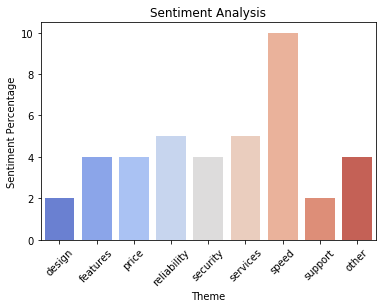

In [6]:
escalated = pd.DataFrame(prod_data, columns= ['SupportTicketID', 'Text', 'Theme', 'Escalated'])
ec = escalated.loc[escalated['Escalated']==1]
ec['Theme'] = pd.Categorical(ec['Theme'], categories=['design','features','price','reliability','security','services','speed','support', 'other'],ordered=True)
categoriesEscalated = ec['Theme'].value_counts()
categoriesEscalated = categoriesEscalated.sort_values(ascending=False)
sns.barplot(x=categoriesEscalated.index,y=categoriesEscalated, palette='coolwarm')
plt.title("Sentiment Analysis")
plt.xlabel("Theme")
plt.ylabel("Sentiment Percentage")
plt.xticks(rotation=45);


In [7]:
ecKeyWords = convert_text_to_JSON(ec)
keys = split_keyword(ecKeyWords)
concatenated = []
for i in keys:
    if 'documents' in i:
        #print(i['documents'])
        #print('-')
        concatenated += i['documents']
keyfreq = {}
for i in concatenated:
    words = i['keyPhrases']
    for keyword in words:
        if keyword in keyfreq:
            keyfreq[keyword] += 1
        else:
            keyfreq[keyword] = 1

sortedFrequencies = sorted(keyfreq.items(), key = lambda x: x[1], reverse=True)
[i for i in sortedFrequencies if i[1] > 1]

[('refund', 5),
 ('days', 4),
 ('order', 4),
 ('product', 3),
 ('time', 3),
 ('package', 3),
 ('person', 2),
 ('website', 2),
 ('things', 2)]

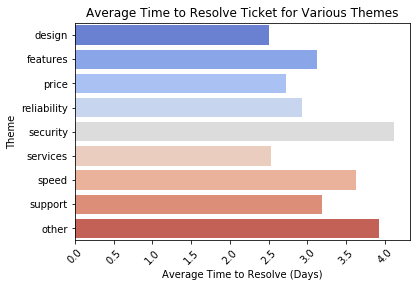

In [8]:
import numpy as np

dateAnalysis = pd.DataFrame(prod_data, columns= ['DateCreated', 'DateCompleted', 'Theme'])
dateAnalysis['DateCreated'] = pd.to_datetime(dateAnalysis['DateCreated'], format='%d/%m/%Y')
dateAnalysis['DateCompleted'] = pd.to_datetime(dateAnalysis['DateCompleted'], format='%d/%m/%Y')
dateAnalysis['TimeToComplete'] = dateAnalysis['DateCompleted'] - dateAnalysis['DateCreated']
dateAnalysis['Theme'] = pd.Categorical(dateAnalysis['Theme'], categories=['design','features','price','reliability','security','services','speed','support', 'other'],ordered=True)
dateAnalysis['Days'] = dateAnalysis['TimeToComplete'].dt.days
timeResolve = dateAnalysis.groupby("Theme").mean()
timeResolve = timeResolve.sort_values(by="Days", ascending=False)

sns.barplot(y=timeResolve.index,x=timeResolve['Days'], palette='coolwarm')
plt.title("Average Time to Resolve Ticket for Various Themes")
plt.xlabel("Average Time to Resolve (Days)")
plt.ylabel("Theme")
plt.xticks(rotation=45);

In [9]:
print(dicts['design'])


        id language                                               text
4    32660       en  Are there any other colors in the bathroom sin...
79   59564       en  I cannot add in my coupons easily on the website.
85    2749       en  I completely hate how your website looks and f...
87    6978       en  I do not like the quality of the dining table ...
92   68034       en  I get that this kind of devices, we donít need...
130  28115       en  I ordered this unit assuming that you have acc...
135  38461       en  I removed the top to clean the unit and now I ...
152  28233       en  I'm digging how cool your website is! Who's th...
179  55126       en  It's so difficult to complete my order. The la...
228  54637       en  The capacity is bogus, I don't understand the ...
233  25475       en  The curtain rod doesn't come with ends to keep...
237  70589       en  The design of the shovel is not good. the head...
241  67349       en  The hammer I purchased is supposed to be ergon...
242  2

In [10]:
allData = pd.DataFrame(prod_data, columns= ['SupportTicketID', 'Text'])
allData = allData.rename(columns={"SupportTicketID": "id", "Text": "text"})
allData.insert(2, "language", "en", True)
allData.dropna(subset=['text'])
dataChunks = split_dataframe(allData)

In [11]:
posText = []
posID = []
negText = []
negID = []
for chunk in dataChunks:
    for item in chunk['documents']:
        if (item['confidenceScores']['positive'] > 0.5):
            posID.append(item['id'])
            for sentence in item['sentences']:
                textAdd += sentence['text'] + " "
            posText.append(textAdd)
        elif (item['confidenceScores']['negative'] > 0.5):
            negID.append(item['id'])
            textAdd = ""
            for sentence in item['sentences']:
                textAdd += sentence['text'] + " "
            negText.append(textAdd)
        
posDF = pd.DataFrame({'id': posID, 'text': posText})
posDF.insert(2, "language", "en", True)
negDF = pd.DataFrame({'id': negID, 'text': negText})
negDF.insert(2, "language", "en", True)
def find_phrases(df, chunk_size = 10):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        ten = df[i*chunk_size:(i+1)*chunk_size]
        dict = ten.to_dict('records')
        format = {"documents":dict}
        phrases = extract_key_phrases(format)
        for item in phrases['documents']:
            for phrase in item['keyPhrases']:
                chunks.append(phrase)
    return chunks
negPhraseChunks = find_phrases(negDF)
posPhraseChunks = find_phrases(posDF)

In [12]:
def find_freq(wordList):
    wordFreq = {}
    for word in wordList:
        if wordFreq.get(word) == None:
            wordFreq[word] = 1
        else:
            wordFreq[word] += 1
    return wordFreq

def sortTuple(tup):  
      
    # getting length of list of tuples 
    lst = len(tup)  
    for i in range(0, lst):  
          
        for j in range(0, lst-i-1):  
            if (tup[j][1] < tup[j + 1][1]):  
                temp = tup[j]  
                tup[j]= tup[j + 1]  
                tup[j + 1]= temp  
    return tup  

posFreq = find_freq(posPhraseChunks)
sortedPos = sorted(posFreq.items(), key = lambda x: x[1], reverse=True)
negFreq = sorted(find_freq(negPhraseChunks).items(), key = lambda x: x[1], reverse=True)
filterPos = [(k,v) for (k,v) in sortedPos if v>2]
filterNeg = [(k,v) for (k,v) in negFreq if v>5]
sortPos = sortTuple(filterPos)
sortNeg = sortTuple(filterNeg)
# print(sortPos)

negWordList = []
negWordFreq = []

for pair in sortNeg:
    negWordList.append(pair[0])
    negWordFreq.append(pair[1])

negWordFreq = pd.DataFrame({'Word': negWordList, 'Frequency': negWordFreq})
display(negWordFreq)

posWordList = []
posWordFreq = []

for pair in sortPos:
    posWordList.append(pair[0])
    posWordFreq.append(pair[1])
posWordFreq = pd.DataFrame({'Word': posWordList, 'Frequency': posWordFreq})
display(posWordFreq)

,Word,Frequency
0,website,15
1,order,13
2,time,12
3,refund,12
4,package,8
5,unit,7
6,item,6
7,days,6
8,way,6


,Word,Frequency
0,website,13
1,order,10
2,way,9
3,status,5
4,coupons,5
5,dishwasher,5
6,shipment,5
7,prices,4
8,products,4
9,expected delivery date,4
